Installieren der Requirements:

In [ ]:
!pip install -r requirements.txt

# Wellenform Visualisierung

<Figure size 500x500 with 0 Axes>

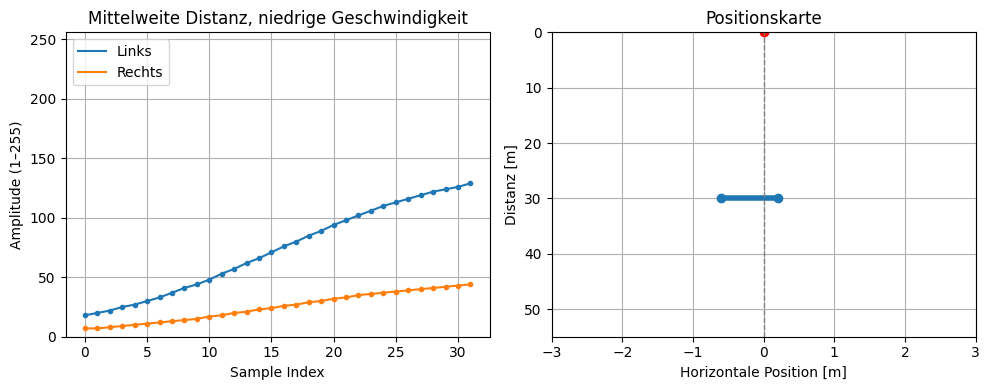

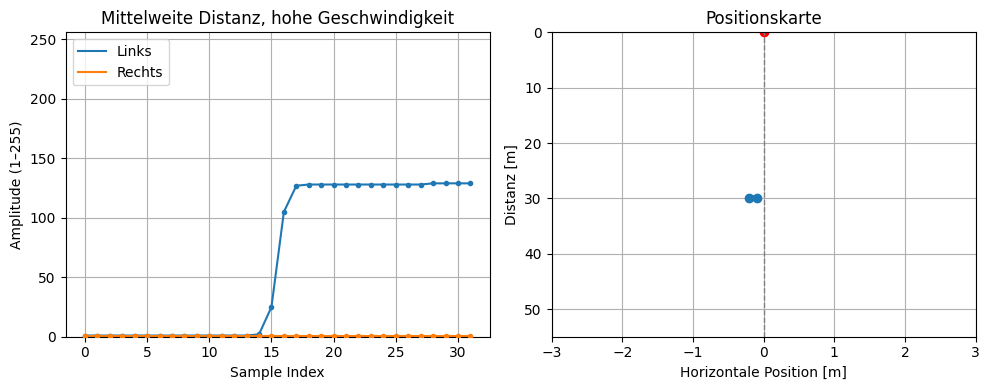

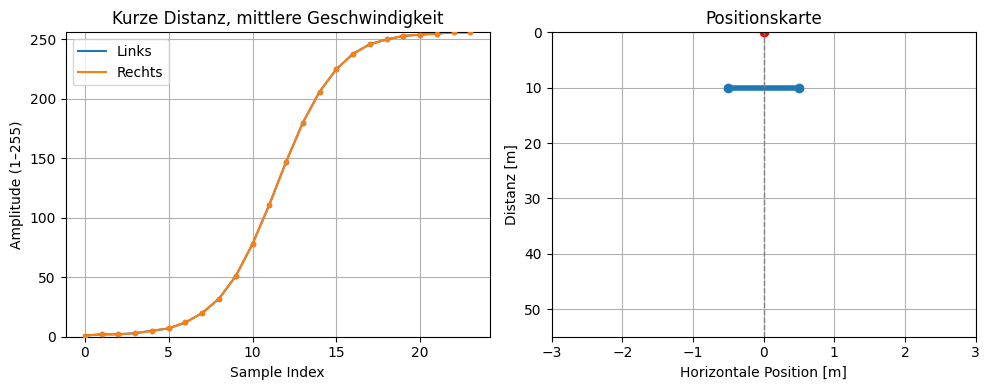

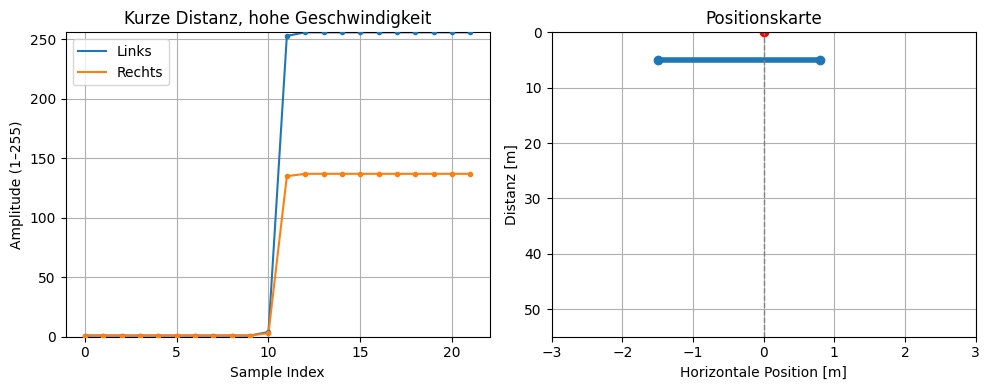

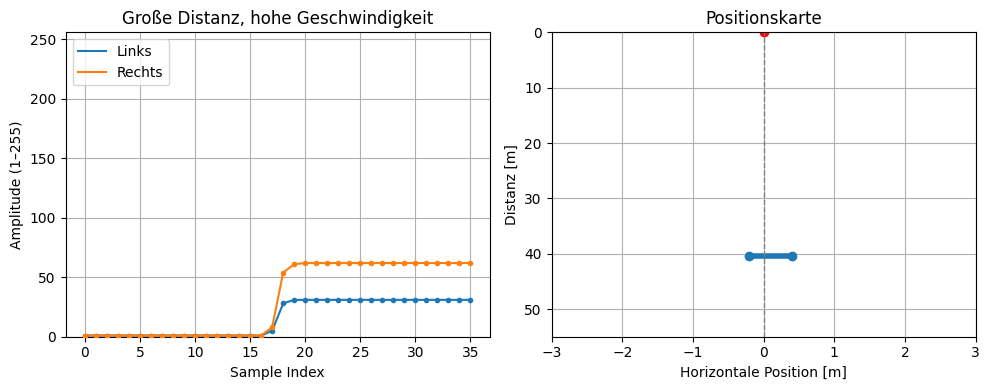

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def clampf(v, vmin, vmax):
    return max(vmin, min(v, vmax))

def float_to_u8(v):
    val = int(v * 255.0 + 0.5)
    return max(0, min(255, val))

def generate_waveform(x, y, speed):
    MIN_SAMPLES = 20
    MAX_SAMPLES = 40
    MIN_SPEED_KMH = 1.0
    MAX_SPEED_KMH = 60.0

    y_clamped = clampf(y, 1.0, 50.0)
    speed_clamped = clampf(speed, MIN_SPEED_KMH, MAX_SPEED_KMH)

    # Sample count: lower y = fewer samples
    norm_y = clampf((y_clamped - 1.0) / (50.0 - 1.0), 0.0, 1.0)
    sample_count = int(MAX_SAMPLES - (MAX_SAMPLES - MIN_SAMPLES) * (1.0 - norm_y) + 0.5)

    # Sigmoid slope from speed
    #speed_norm = (speed_clamped - MIN_SPEED_KMH) / (MAX_SPEED_KMH - MIN_SPEED_KMH)
    #k = 2.0 + speed_norm * (20.0 - 2.0)
    # A steeper slope for higher speeds
    # Sigmoid slope from speed
    speed_norm = (speed_clamped - MIN_SPEED_KMH) / (MAX_SPEED_KMH - MIN_SPEED_KMH)
    k = 2.0 * (10 ** (speed_norm * 2))  # grows from 2 to 200

    #s_values = 1.0 / (1.0 + np.exp(-100.0 * (t_values - 0.5)))

    # Left/right factor based on footprint
    left_width = abs(x[0])
    right_width = abs(x[1])
    total_width = left_width + right_width if (left_width + right_width) > 0 else 1.0

    # Determine side presence
    has_left = x[0] < 0
    has_right = x[1] > 0

    left_factor = (left_width / total_width) if has_left else 0.0
    right_factor = (right_width / total_width) if has_right else 0.0

    # Amplitude: lower y = higher amplitude
    #base_amplitude = clampf(1.0 - ((y_clamped - 1.0) / (50.0 - 1.0)), 0.0, 1.0) # Wrong approach
    base_amplitude = clampf((50.0 - y_clamped) / (50.0 - 10.0), 0.0, 1.0)

    # Generate normalized time vector and sigmoid values
    t_values = np.linspace(0, 1, sample_count)
    s_values = 1.0 / (1.0 + np.exp(-k * (t_values - 0.5)))

    # Normalize sigmoid so max(s_values) == 1.0
    s_values /= np.max(s_values)

    # Compute unscaled waveform
    left_raw = [left_factor * s for s in s_values]
    right_raw = [right_factor * s for s in s_values]

    # Zero out if needed
    if x[0] < 0 and x[1] < 0:
        right_raw = [0.0] * sample_count
    elif x[0] > 0 and x[1] > 0:
        left_raw = [0.0] * sample_count

    # Compute global max of both channels
    max_val = max(max(left_raw), max(right_raw), 1e-5)  # avoid divide-by-zero

    # Normalize to full 255 amplitude if y is close
    scaling = clampf((50.0 - y_clamped) / (50.0 - 10.0), 0.0, 1.0)
    scale = 255 * scaling / max_val

    # Scale this shit
    left_samples = [int(v * scale + 1.0 + 0.5) for v in left_raw]
    right_samples = [int(v * scale + 1.0 + 0.5) for v in right_raw]

    return t_values, left_samples, right_samples

def plot_map_view(ax, x, y, label=None):
    x0, x1 = x
    ax.hlines(y, x0, x1, linewidth=4, label=label)
    ax.plot([x0, x1], [y, y], 'o')
    ax.plot(0, 0, 'ro')  # <-- red dot at (0, 0)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)
    ax.set_xlim(-3, 3)
    ax.set_ylim(0, 55)
    ax.invert_yaxis()  # flip y-axis so 0 is bottom, 50 is top
    ax.set_xlabel("Horizontale Position [m]")
    ax.set_ylabel("Distanz [m]")
    ax.set_title("Positionskarte")
    ax.grid(True)
    if label:
        ax.legend().set_visible(False)

def plot_waveform_and_map(x, y, speed, label=None):
    t, left, right = generate_waveform(x, y, speed)

    sample_indices = list(range(len(t)))

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Waveform plot
    axs[0].plot(sample_indices, left, label="Links")
    axs[0].plot(sample_indices, right, label="Rechts")

    # Add red 'x' markers at each sample
    axs[0].scatter(sample_indices, left, marker='.', zorder=3)
    axs[0].scatter(sample_indices, right, marker='.', zorder=3)

    axs[0].set_title(f"{label or ''}")
    axs[0].set_xlabel("Sample Index")
    axs[0].set_ylabel("Amplitude (1–255)")
    axs[0].legend()
    axs[0].set_ylim(0, 256)
    axs[0].grid(True)
    if label:
        axs[0].legend(loc="upper left")

    plot_map_view(axs[1], x, y, label=label)

    plt.tight_layout()
    plt.show()

plt.figure(figsize=(5, 5))

plot_waveform_and_map(x=[-0.6, 0.2], y=30, speed=10, label="Mittelweite Distanz, niedrige Geschwindigkeit")
plot_waveform_and_map(x=[-0.2, -0.1], y=30, speed=50, label="Mittelweite Distanz, hohe Geschwindigkeit")
plot_waveform_and_map(x=[-0.5, 0.5], y=10, speed=25, label="Kurze Distanz, mittlere Geschwindigkeit")
plot_waveform_and_map(x=[-1.5, 0.8], y=5, speed=59, label="Kurze Distanz, hohe Geschwindigkeit")
plot_waveform_and_map(x=[-0.2, 0.4], y=40.5, speed=55.3, label="Große Distanz, hohe Geschwindigkeit")